In [1]:
from pathlib import Path
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 

import numpy as np
from petsc4py import PETSc
import pyvista as pv
import matplotlib as mpl


import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem import petsc
from dolfinx.fem.petsc import LinearProblem

from dolfinx.fem.petsc import (
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc)

In [12]:
t = 0 
T = (60*60*24) * 365# final time (days)
time_steps = 100
H = -5 # depths keep positive 
H = abs(H)  # incase if havent kept posative
nx = 50
dt = T / time_steps  
mv = 0
cv = 0
load = 100 # applied load 

c_1 = 2.0e-6  # m^2/s 

layers = [
    {"z_top": 0.0, "z_bot": 1.5, "cv": 2.0e-3},
    {"z_top": 1.5, "z_bot": 3.5, "cv": 5.0e-4},
    {"z_top": 3.5, "z_bot": 5.0, "cv": 1.0e-3},
]


In [13]:
# interval mesh | MUST keep in positional arguemnts i.e. "comm", "nx"
msh = mesh.create_interval(
    comm=MPI.COMM_WORLD,
    nx=nx,
    points=[0.0, abs(H)],
)

initial_condition = lambda x: np.full(x.shape[1], load)

V = fem.functionspace(msh, ("Lagrange", 1))

# Solution functions
u_n = fem.Function(V)
u_n.name = "u_n"
# Initial condition
u_n.interpolate(initial_condition) 
# boundary creation


fdim = msh.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    msh, fdim, 
    marker = lambda x: np.isclose(x[0], H))

dofs = fem.locate_dofs_topological(V=V, entity_dim= fdim, entities= boundary_facets)
bc = fem.dirichletbc( value= PETSc.ScalarType(0), dofs= dofs, V=V)


In [14]:
# XDMFile  output can be viewed easily on paraview 
# xdmf = io.XDMFFile(msh.comm, "Results/output.xdmf", "w" )
# xdmf.write_mesh(msh)

In [15]:
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
# xdmf.write_function(uh,t)

# varational form
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
 # PETSc make sure the background stuff doesnt explode
c = fem.Constant(msh, c_1)

a = (u * v) * ufl.dx + dt * c * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = (u_n) * v * ufl.dx
bilinear_form = fem.form(a)
linear_form = fem.form(L)

A = assemble_matrix(bilinear_form, bcs = [bc])
A.assemble()
b = petsc.create_vector(fem.extract_function_spaces(linear_form))

In [16]:
# creating linear solver 
solver = PETSc.KSP().create(msh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)



In [17]:
u_hist = np.zeros((time_steps + 1, uh.x.array.size), dtype=float)
u_hist[0, :] = uh.x.array.copy()   # initial state
x = V.mesh.geometry.x[:, 0].copy()


for i in range(time_steps):
    with b.localForm() as loc_b:
        loc_b.set(0.0)
    assemble_vector(b, linear_form)

    apply_lifting(b ,[bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,
                  mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve
    solver.solve(b, uh.x.petsc_vec)

    # Update time-step solution
    u_n.x.array[:] = uh.x.array
    u_n.x.scatter_forward()

    u_hist[i + 1, :] = uh.x.array.copy()

# xdmf.close()
A.destroy()
b.destroy()
solver.destroy



<bound method KSP.destroy of <petsc4py.PETSc.KSP object at 0x1614e3e70>>

In [18]:
print("u_hist shape:", u_hist.shape)
print("u_hist min/max:", float(np.min(u_hist)), float(np.max(u_hist)))
print("Any NaNs?:", np.isnan(u_hist).any())
print("Any infs?:", np.isinf(u_hist).any())


u_hist shape: (101, 51)
u_hist min/max: 0.0 100.0
Any NaNs?: False
Any infs?: False


In [19]:
import pandas as pd 

u_hist = pd.DataFrame(u_hist)

u_hist

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
1,99.632732,99.629813,99.621009,99.606180,99.585091,99.557406,99.522685,99.480376,99.429807,99.370173,...,67.824562,63.504255,58.603779,53.045232,46.740249,39.588600,31.476598,22.275286,11.838391,0.0
2,98.474317,98.465117,98.437418,98.390919,98.325118,98.239305,98.132557,98.003730,97.851450,97.674104,...,49.552241,45.081971,40.320381,35.269885,29.938793,24.342854,18.507099,12.468055,6.276380,0.0
3,96.358989,96.342199,96.291711,96.207163,96.087951,95.933228,95.741901,95.512628,95.243816,94.933618,...,39.802083,35.834613,31.720912,27.471271,23.098399,18.617488,14.046197,9.404530,4.714567,0.0
4,93.384125,93.360524,93.289613,93.171068,93.004350,92.788706,92.523172,92.206570,91.837517,91.414424,...,33.925754,30.411702,26.811830,23.134279,19.388110,15.583244,11.730384,7.840895,3.926677,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.386362,0.386172,0.385600,0.384648,0.383316,0.381606,0.379519,0.377057,0.374224,0.371021,...,0.107792,0.096084,0.084282,0.072397,0.060440,0.048424,0.036360,0.024260,0.012136,0.0
97,0.363719,0.363540,0.363001,0.362105,0.360851,0.359241,0.357277,0.354960,0.352292,0.349277,...,0.101474,0.090453,0.079343,0.068154,0.056898,0.045586,0.034229,0.022838,0.011425,0.0
98,0.342403,0.342234,0.341727,0.340883,0.339703,0.338187,0.336338,0.334157,0.331646,0.328807,...,0.095527,0.085152,0.074693,0.064160,0.053564,0.042914,0.032223,0.021500,0.010755,0.0
99,0.322336,0.322177,0.321700,0.320905,0.319794,0.318368,0.316627,0.314573,0.312209,0.309537,...,0.089929,0.080162,0.070315,0.060400,0.050424,0.040399,0.030334,0.020240,0.010125,0.0


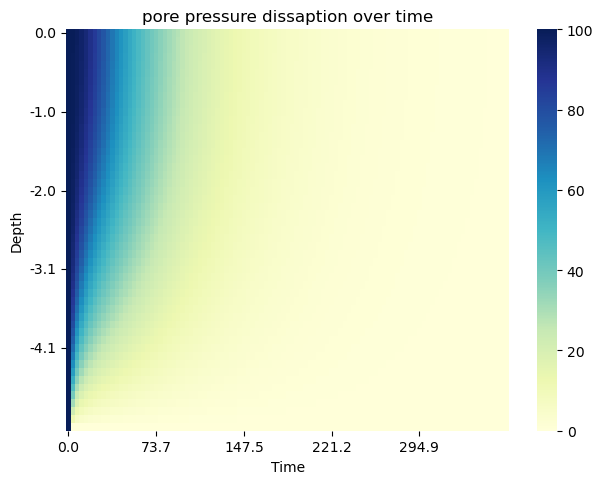

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

time = np.linspace(0,T,time_steps)/(60*60*24)
depth = np.linspace(0, -abs(H), nx)
pore_pressure = u_hist

kx = max(1, len(time)//5)    # ~8 labels across, auto
ky = max(1, len(depth)//5)  # ~10 labels down, auto 


ax = sns.heatmap(pore_pressure.T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.title("pore pressure dissaption over time")
plt.show()
